# Comparação de Métodos de Geração de Sinais Sintéticos

Este notebook compara dois métodos de geração de sinais de falha em rolamentos:
1. **Método FFT (Soma de Senóides)**: Baseado no espectro de frequências calculado.
2. **Método Impulso (Resposta ao Impulso)**: Baseado na convolução de um trem de impulsos com a resposta estrutural.

O objetivo é visualizar as diferenças no domínio da frequência (FFT) para validar a qualidade dos sinais gerados.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Adicionar src ao path
sys.path.append(os.path.abspath('src'))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

import general_sam_analysis_utils as gsau

# Configurações
RPM = 1730
FS = 12000

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

### 1. Carregar Sinal Normal Base
Usaremos um segmento real 'Normal' com 1730 RPM como ruído de fundo base para ambos os métodos.

In [2]:
normal_seg = None
for k, v in ssd.dicionario_treino.items():
    if v['rotacao_rpm'].iloc[0] == RPM:
        normal_seg = v['amplitude'].values
        print(f"Segmento Normal Carregado: {k}")
        break

if normal_seg is None:
    # Fallback
    k = list(ssd.dicionario_treino.keys())[0]
    normal_seg = ssd.dicionario_treino[k]['amplitude'].values
    print(f"Aviso: RPM exato não encontrado. Usando segmento: {k}")

n = len(normal_seg)
duration = n / FS

Segmento Normal Carregado: 1730_Normal_DE_treino_seg_0


### 2. Funções Auxiliares de Plotagem

In [3]:
def plot_comparison(fault_name, sig_fft_comb, sig_impulse_comb, characteristic_freq=None, sig_real=None, f_min=0, f_max=None):
    rows = 3 if sig_real is not None else 2
    fig, axes = plt.subplots(rows, 1, figsize=(12, 5*rows), constrained_layout=True)
    
    # Internal FFT function with limiting
    def calc_fft_and_process(sig):
        # Apply Antialiasing Filter
        sig_filt = gsau.apply_antialiasing_filter(sig, FS)

        # Apply Hanning Window
        sig_win = gsau.apply_hanning_window(sig_filt)
        
        # Calculate FFT
        yf = fft(sig_win)
        xf = fftfreq(len(sig_win), 1/FS)[:len(sig_win)//2]
        mag = 2.0/len(sig_win) * np.abs(yf[0:len(sig_win)//2])
        
        # Limit Spectrum
        # Handle f_max=None by using the maximum available frequency
        upper_limit = f_max if f_max is not None else np.max(xf)
        return gsau.limit_spectrum_frequency(xf, mag, f_min, upper_limit)

    # Plot 1: FFT Method
    x1_c, y1_c = calc_fft_and_process(sig_fft_comb)
    axes[0].plot(x1_c, y1_c, color='black', alpha=0.7, label='Sinal Combinado (Ruído + Falha)')
    if characteristic_freq:
        axes[0].axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Freq. Característica: {characteristic_freq:.1f}Hz')
    
    axes[0].set_title(f"{fault_name} - Método FFT (Soma Senóides)", fontsize=12, fontweight='bold')
    axes[0].set_ylabel("Magnitude")
    if f_max:
        axes[0].set_xlim(f_min, f_max)
    else:
        axes[0].set_xlim(0, 2000) # Default cutoff if no limits
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')

    # Plot 2: Impulse Method
    x2_c, y2_c = calc_fft_and_process(sig_impulse_comb)
    axes[1].plot(x2_c, y2_c, color='black', alpha=0.7, label='Sinal Combinado (Ruído + Falha)')
    if characteristic_freq:
        axes[1].axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Freq. Característica: {characteristic_freq:.1f}Hz')

    axes[1].set_title(f"{fault_name} - Método Impulso (Convolução)", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("Magnitude")
    if rows == 2:
        axes[1].set_xlabel("Frequência (Hz)")
    if f_max:
        axes[1].set_xlim(f_min, f_max)
    else:
        axes[1].set_xlim(0, 2000)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right')
    
    # Plot 3: Real Signal (Optional)
    if sig_real is not None:
        x3_c, y3_c = calc_fft_and_process(sig_real)
        axes[2].plot(x3_c, y3_c, color='blue', alpha=0.7, label='Sinal Real')
        if characteristic_freq:
            axes[2].axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Freq. Característica: {characteristic_freq:.1f}Hz')
        
        axes[2].set_title(f"{fault_name} - Sinal Real", fontsize=12, fontweight='bold')
        axes[2].set_ylabel("Magnitude")
        axes[2].set_xlabel("Frequência (Hz)")
        if f_max:
            axes[2].set_xlim(f_min, f_max)
        else:
            axes[2].set_xlim(0, 2000)
        axes[2].grid(True, alpha=0.3)
        axes[2].legend(loc='upper right')
    
    plt.show()

### 3. Geração e Comparação por Tipo de Falha

In [5]:
# Preparar geração do método de impulso para todos os tipos de uma vez
# CORREÇÃO: Criar DataFrame corretamente para evitar erro de dimensão
df_dummy = pd.DataFrame({'amplitude': normal_seg})
df_dummy['rotacao_rpm'] = RPM
df_dummy['tipo_falha'] = 'Normal'

dummy_dict = {'temp_normal': df_dummy}

print("Gerando sinais pelo método de Impulso...")
# Usamos multiplicador maior para visualizar bem o impacto
df_impulse = gid.gerar_dados_sinteticos_treino(
    dicionario_treino=dummy_dict,
    TAXA_AMOSTRAL=FS,
    params_drive_end=gid.params_drive_end,
    amplitudes_referencia=gid.amplitudes_referencia,
    multiplicadores=[1], # Amplitude x1 (Realista)
    fases_para_adicionar_rad=[0]
)

Gerando sinais pelo método de Impulso...
Usando 999 modos naturais para Outer Race (primeiro: 5037.1 Hz)
Usando 999 modos naturais para Inner Race (primeiro: 14142.8 Hz)
Gerando Sinais... (damp=0.1, dur=0.1s, mod=0.5)
Geração concluída. Total de 4 segmentos de treino.


Buscando sinal real: RPM=1730, Tipo=Pista Externa, Diam=0.021"
Sinal ENCONTRADO! Chave: 1730_OR@6_21_DE_seg_0, Tam: 4096
Plotando comparativo... Real Sig: Presente


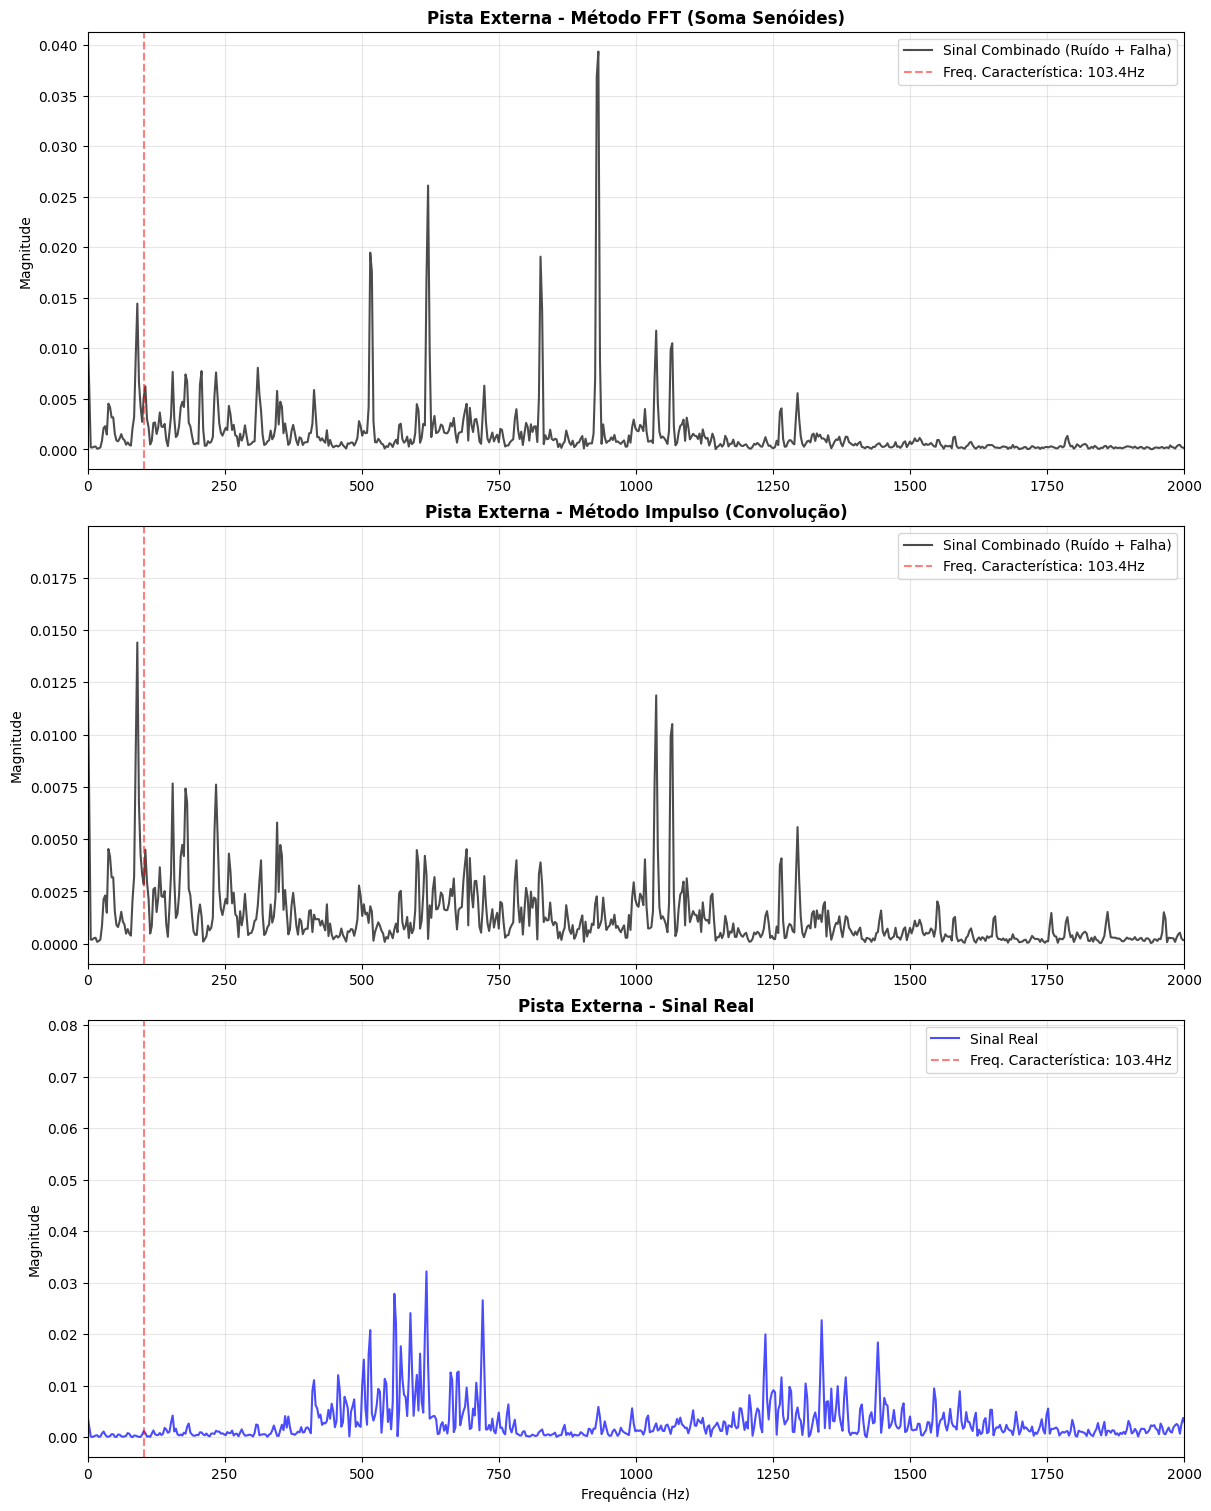

In [6]:
# --- Pista Externa ---

# 1. Gerar FFT Method
spec_outer = bu.calcular_espectro_outer_race(fault_diameter_mm=0.5, rpm=RPM, K=0.05) # Ajuste K para ficar comparável se necessário
sig_outer_gen = gsd.synthesize_time_signal(spec_outer, duration=duration, fs=FS)
# Ajuste de tamanho
sig_outer_gen = sig_outer_gen[:n] if len(sig_outer_gen) > n else np.pad(sig_outer_gen, (0, n - len(sig_outer_gen)))
final_outer_fft = normal_seg + sig_outer_gen

# 2. Pegar Impulse Method
row_outer = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Externa'].iloc[0]
final_outer_imp = row_outer['sinal_final']
final_outer_imp_pure = row_outer['sinal_puro']

# Calculate char freq
coeffs_out = bu.calculate_tandon_coefficients(fault_diameter_mm=0.0, rpm=RPM, fault_type='outer')
freq_out = coeffs_out['frequencies']['defect_freq_hz']


# 3. Pegar Real Signal
real_sig = None
target_diam = '0.021"'
target_fault = 'Pista Externa'
target_rpm = RPM

print(f"Buscando sinal real: RPM={target_rpm}, Tipo={target_fault}, Diam={target_diam}")

for key, df_seg in ssd.dicionario_teste.items():
    try:
        # Casting para evitar erros de tipos (numpy int vs int, etc)
        meta_rpm = int(df_seg['rotacao_rpm'].iloc[0])
        meta_type = str(df_seg['tipo_falha'].iloc[0])
        meta_diam = str(df_seg['diametro_falha'].iloc[0])
        
        if meta_rpm == int(target_rpm) and meta_type == target_fault and meta_diam == target_diam:
            real_sig = df_seg['amplitude'].values
            print(f"Sinal ENCONTRADO! Chave: {key}, Tam: {len(real_sig)}")
            
            # Adjust size
            if len(real_sig) < n:
                 real_sig = np.pad(real_sig, (0, n - len(real_sig)))
            else:
                 real_sig = real_sig[:n]
            break
    except Exception as e:
        continue

if real_sig is None:
    print(f"AVISO: Sinal real NÃO encontrado no dicionário!")

print(f"Plotando comparativo... Real Sig: {'None' if real_sig is None else 'Presente'}")
plot_comparison("Pista Externa", final_outer_fft, final_outer_imp, characteristic_freq=freq_out, sig_real=real_sig)

Buscando sinal real: RPM=1730, Tipo=Pista Interna, Diam=0.021"
Sinal ENCONTRADO! Chave: 1730_IR_21_DE_seg_0, Tam: 4096
Plotando comparativo... Real Sig: Presente


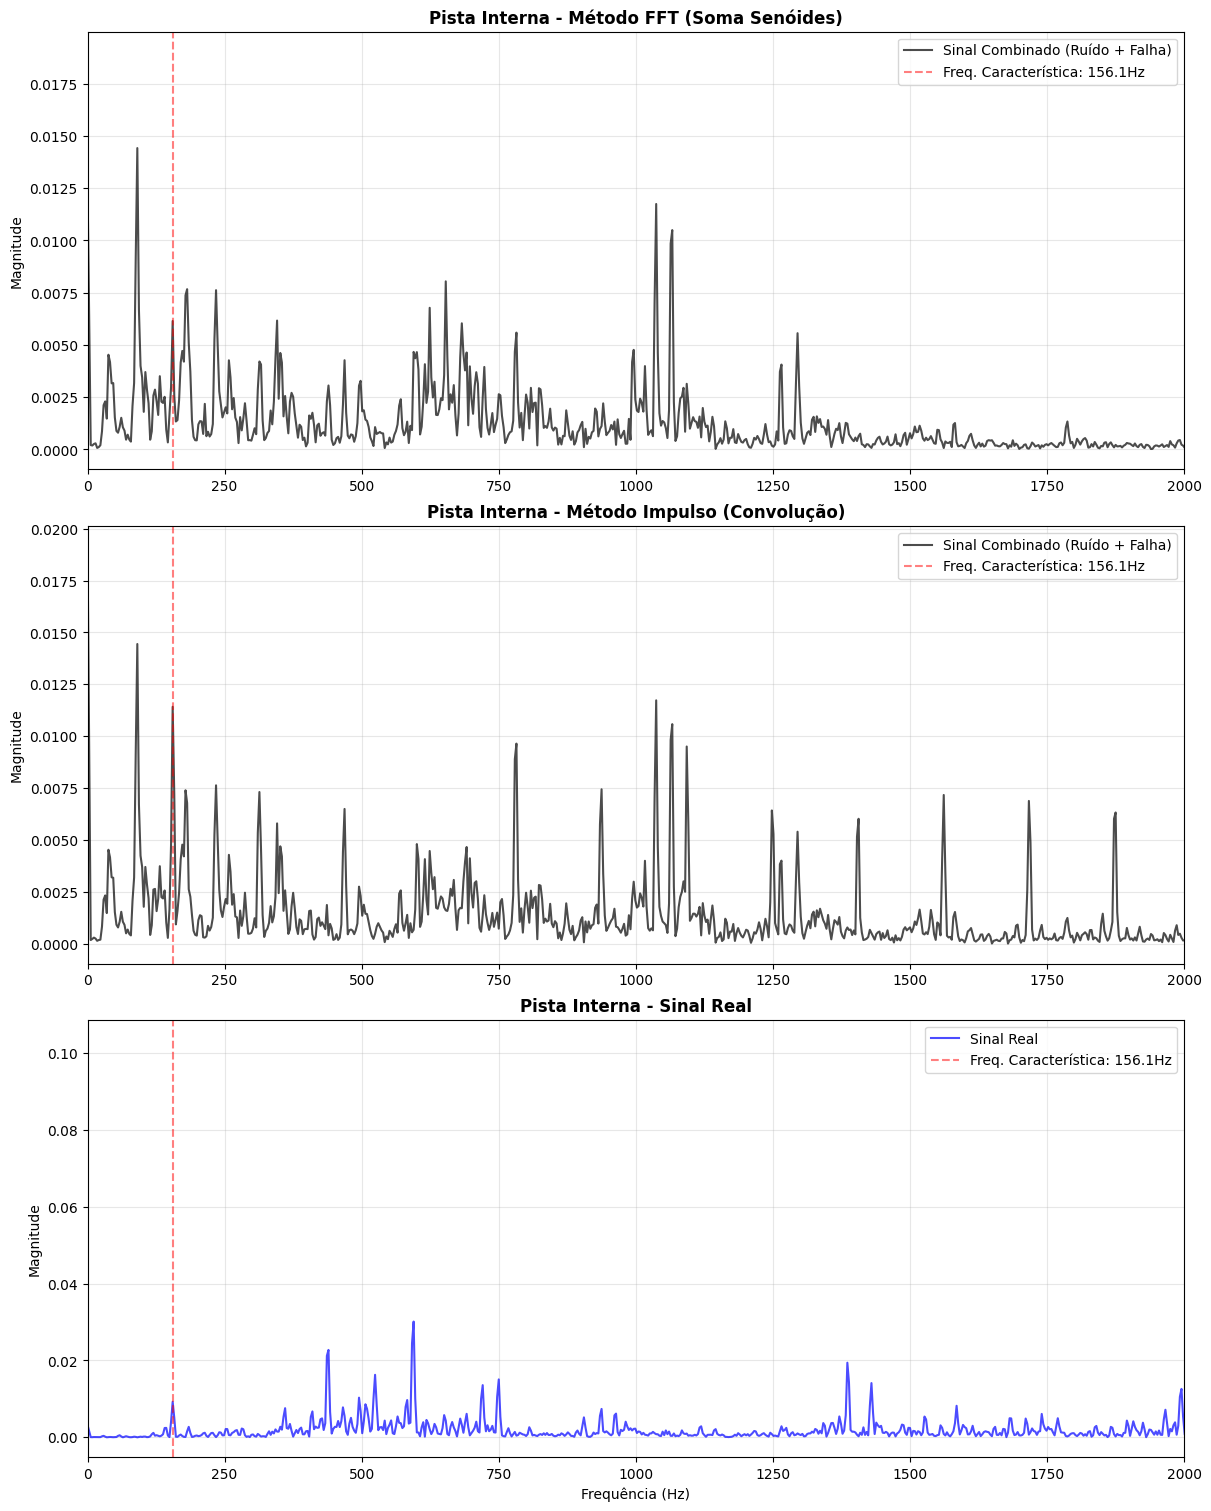

In [7]:
# --- Pista Interna ---

# 1. Gerar FFT Method
spec_inner = bu.calcular_espectro_inner_completo(fault_diameter_mm=0.5, rpm=RPM, K=0.2)
sig_inner_gen = gsd.synthesize_time_signal(spec_inner, duration=duration, fs=FS)
sig_inner_gen = sig_inner_gen[:n] if len(sig_inner_gen) > n else np.pad(sig_inner_gen, (0, n - len(sig_inner_gen)))
final_inner_fft = normal_seg + sig_inner_gen

# 2. Pegar Impulse Method
row_inner = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Interna'].iloc[0]
final_inner_imp = row_inner['sinal_final']
final_inner_imp_pure = row_inner['sinal_puro']

# Calculate char freq
coeffs_in = bu.calculate_tandon_coefficients(fault_diameter_mm=0.0, rpm=RPM, fault_type='inner')
freq_in = coeffs_in['frequencies']['defect_freq_hz']


# 3. Pegar Real Signal
real_sig = None
target_diam = '0.021"'
target_fault = 'Pista Interna'
target_rpm = RPM

print(f"Buscando sinal real: RPM={target_rpm}, Tipo={target_fault}, Diam={target_diam}")

for key, df_seg in ssd.dicionario_teste.items():
    try:
        # Casting para evitar erros de tipos (numpy int vs int, etc)
        meta_rpm = int(df_seg['rotacao_rpm'].iloc[0])
        meta_type = str(df_seg['tipo_falha'].iloc[0])
        meta_diam = str(df_seg['diametro_falha'].iloc[0])
        
        if meta_rpm == int(target_rpm) and meta_type == target_fault and meta_diam == target_diam:
            real_sig = df_seg['amplitude'].values
            print(f"Sinal ENCONTRADO! Chave: {key}, Tam: {len(real_sig)}")
            
            # Adjust size
            if len(real_sig) < n:
                 real_sig = np.pad(real_sig, (0, n - len(real_sig)))
            else:
                 real_sig = real_sig[:n]
            break
    except Exception as e:
        continue

if real_sig is None:
    print(f"AVISO: Sinal real NÃO encontrado no dicionário!")

print(f"Plotando comparativo... Real Sig: {'None' if real_sig is None else 'Presente'}")
plot_comparison("Pista Interna", final_inner_fft, final_inner_imp, characteristic_freq=freq_in, sig_real=real_sig)

Buscando sinal real: RPM=1730, Tipo=Esfera, Diam=0.021"
Sinal ENCONTRADO! Chave: 1730_B_21_DE_seg_0, Tam: 4096
Plotando comparativo... Real Sig: Presente


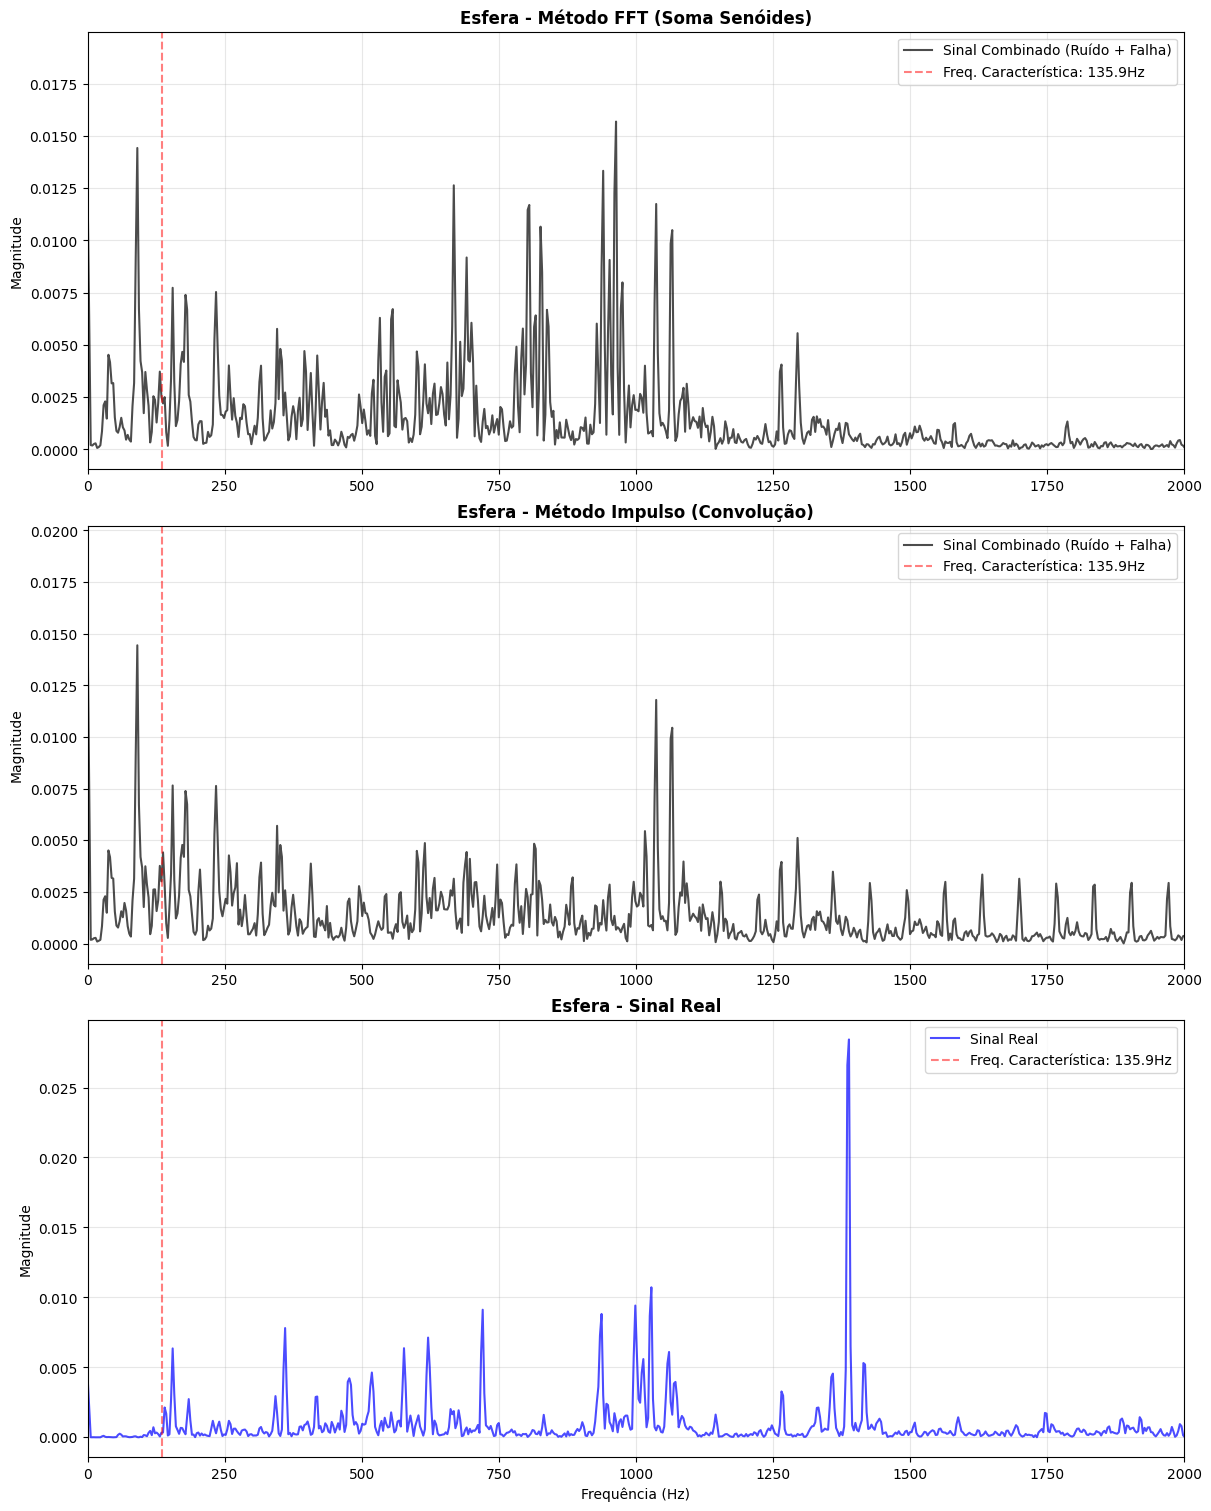

In [8]:
# --- Esfera ---

# 1. Gerar FFT Method
spec_ball = bu.calcular_espectro_ball_completo(fault_diameter_mm=0.5, rpm=RPM, K=0.05)
sig_ball_gen = gsd.synthesize_time_signal(spec_ball, duration=duration, fs=FS)
sig_ball_gen = sig_ball_gen[:n] if len(sig_ball_gen) > n else np.pad(sig_ball_gen, (0, n - len(sig_ball_gen)))
final_ball_fft = normal_seg + sig_ball_gen

# 2. Pegar Impulse Method
row_ball = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Esfera'].iloc[0]
final_ball_imp = row_ball['sinal_final']
final_ball_imp_pure = row_ball['sinal_puro']

# Calculate char freq
coeffs_ball = bu.calculate_tandon_coefficients(fault_diameter_mm=0.0, rpm=RPM, fault_type='ball')
freq_ball = coeffs_ball['frequencies']['defect_freq_hz']


# 3. Pegar Real Signal
real_sig = None
target_diam = '0.021"'
target_fault = 'Esfera'
target_rpm = RPM

print(f"Buscando sinal real: RPM={target_rpm}, Tipo={target_fault}, Diam={target_diam}")

for key, df_seg in ssd.dicionario_teste.items():
    try:
        # Casting para evitar erros de tipos (numpy int vs int, etc)
        meta_rpm = int(df_seg['rotacao_rpm'].iloc[0])
        meta_type = str(df_seg['tipo_falha'].iloc[0])
        meta_diam = str(df_seg['diametro_falha'].iloc[0])
        
        if meta_rpm == int(target_rpm) and meta_type == target_fault and meta_diam == target_diam:
            real_sig = df_seg['amplitude'].values
            print(f"Sinal ENCONTRADO! Chave: {key}, Tam: {len(real_sig)}")
            
            # Adjust size
            if len(real_sig) < n:
                 real_sig = np.pad(real_sig, (0, n - len(real_sig)))
            else:
                 real_sig = real_sig[:n]
            break
    except Exception as e:
        continue

if real_sig is None:
    print(f"AVISO: Sinal real NÃO encontrado no dicionário!")

print(f"Plotando comparativo... Real Sig: {'None' if real_sig is None else 'Presente'}")
plot_comparison("Esfera", final_ball_fft, final_ball_imp, characteristic_freq=freq_ball, sig_real=real_sig)